In [39]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, RandomizedSearchCV
import warnings
import os
import sweetviz as sv
from IPython.display import IFrame
import time
import requests
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
import joblib
import optuna
from lightgbm import early_stopping
warnings.filterwarnings('ignore')

# データ取得

In [40]:
# データの読み込みと文字列として保存されている日時情報を日時型のデータに変換
df = pd.read_csv('merged_btc_ohlcv_etf.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
for col in df.columns:
    if df[col].dtype == 'object':  # 文字列型の列のみ変換を試みる
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [41]:
# タイムスタンプでソートとインデックスのリセット
df.sort_values('timestamp', inplace=True)#inplaceで新しいdataframeを作成せず元のを変更
# 列をインデックス（行ラベル）として設定
df.set_index('timestamp', inplace=True)

In [42]:
# 欠損値処理
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

In [43]:
# 特徴量エンジニアリング
# 移動平均線の計算
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['SMA_100'] = df['close'].rolling(window=100).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# 指数移動平均線の計算
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()

# RSIの計算
def compute_RSI(data, time_window):
    diff = data.diff(1) #1つ前の行との違い
    up_chg = diff.clip(lower=0) #差分が負の物は0に変換
    down_chg = -diff.clip(upper=0) #差分が0より大きいものを全て0に置き換える
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean() #価格が上昇した指数移動平均
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    rs = up_chg_avg / down_chg_avg #上昇した強さと下落した強さの比率
    rsi = 100 - 100 / (1 + rs) 
    return rsi

df['RSI_14'] = compute_RSI(df['close'], 14)

# MACDの計算
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# ボリンジャーバンドの計算
df['STD_20'] = df['close'].rolling(window=20).std() #stdは標準偏差(データのばらつき度合い)を計算
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

# 遅延特徴量の作成
for lag in range(1, 6): #shift(lag) は、df['close'] のデータを lag 分だけ下にシフト
    df[f'lag_{lag}'] = df['close'].shift(lag) #lag_1からlag_5 までの5つの遅延列が作成

# 時間に関する特徴量
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek #曜日は0から6の値で表される

#ATR（平均真の範囲、Average True Range）
df['TR'] = df['high'] - df['low']
df['ATR_14'] = df['TR'].rolling(window=14).mean()

#ADX（平均方向性指数、Average Directional Index）
def compute_ADX(data, period=14):
    high = data['high']
    low = data['low']
    close = data['close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr = high.combine(low, max) - low.combine(close.shift(), min)

    atr = tr.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/period).mean() / atr))
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    
    return adx

df['ADX_14'] = compute_ADX(df)

#CCI（商品チャンネル指数、Commodity Channel Index）
df['TP'] = (df['high'] + df['low'] + df['close']) / 3
df['CCI_14'] = (df['TP'] - df['TP'].rolling(window=14).mean()) / (0.015 * df['TP'].rolling(window=14).std())

#OBV（オンバランスボリューム、On-Balance Volume）
df['OBV'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()

#Stochastic Oscillator（ストキャスティクス）
df['L14'] = df['low'].rolling(window=14).min()
df['H14'] = df['high'].rolling(window=14).max()
df['%K'] = 100 * (df['close'] - df['L14']) / (df['H14'] - df['L14'])
df['%D'] = df['%K'].rolling(window=3).mean()

df['Volatility'] = df['close'].rolling(window=10).std()
df['Volume_Change'] = df['volume'].pct_change()

for lag in [1, 2, 7, 30]:
    df[f'close_lag_{lag}'] = df['close'].shift(lag)

for lag in [1, 2, 7, 30]:
    df[f'etf_total_lag_{lag}'] = df['Total'].shift(lag)


In [44]:
# 目標変数の作成
df['return'] = df['close'].pct_change().shift(-1) #前の行とのパーセンテージの変化
df['target'] = (df['return'] > 0).astype(int) #価格が上昇したらTrue

In [45]:
# 欠損値の削除
df.dropna(subset=['target'], inplace=True)

In [46]:
# 特徴量と目標変数の定義
features = ['open', 'high', 'low', 'close', 'volume', 'IBIT', 'FBTC', 'BITB', 'ARKB', 'BTCO', 'EZBC', 'BRRR', 'HODL', 'BTCW', 'GBTC', 'BTC', 'Total', 'SMA_10', 'SMA_30','SMA_100', 'SMA_200',
            'EMA_20',  'EMA_200', 'RSI_14', 'MACD', 'Signal_Line',
            'Upper_Band', 'Lower_Band', 'ATR_14', 'ADX_14', 'CCI_14', 'OBV', '%K', '%D', 'hour', 'day_of_week', 'close_lag_1', 'close_lag_2', 'close_lag_7', 'close_lag_30', 'etf_total_lag_1', 'etf_total_lag_2', 'etf_total_lag_7', 'etf_total_lag_30'] + [f'lag_{lag}' for lag in range(1,6)]

X = df[features]
y = df['target'] #価格が上昇すれば1下落すれば0

In [47]:
# データの分割（時間ベースでの分割）
start_date = '2020-01-01'
split_date = '2024-11-01'
end_date = '2024-11-30'  # 日付の範囲を正しく指定

# インデックスが日時型であることを確認
X.index = pd.to_datetime(X.index)
y.index = pd.to_datetime(y.index)

# 条件式を修正してデータを分割
X_train = X[(X.index > start_date) & (X.index < split_date)]
X_test = X[(X.index >= split_date) & (X.index <= end_date)]
y_train = y[(y.index > start_date) & (y.index < split_date)]
y_test = y[(y.index >= split_date) & (y.index <= end_date)]


In [48]:
# LightGBM用のデータセットを作成
lgb_train = lgb.Dataset(X_train, y_train)  # 訓練データをLightGBMのデータセット形式に変換
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)  # 評価データも同様に変換し、訓練データを基準に指定

# パラメータの設定
params = {
    'objective': 'binary',  # 目的関数を2値分類問題に設定
    'metric': 'binary_logloss',  # モデル評価の指標としてbinary_loglossを指定
    'num_iterations': 10000,  # 最大のイテレーション数を指定（モデルの学習を行う繰り返し数）
    'verbosity': -1,  # ログ出力の詳細度を制御、-1で詳細な出力を抑制
}

# モデルの訓練
print('Starting training...')
gbm = lgb.train(
    params,  # 指定したパラメータでモデルを訓練
    lgb_train,  # 訓練用データセット
    valid_sets=[lgb_train, lgb_eval],  # 訓練と評価データセットを指定し、途中経過をモニタリング
    num_boost_round=1000,  # 最大1000回のブースティングを実行
    callbacks=[lgb.early_stopping(stopping_rounds=50)]  # 50回連続で改善が見られない場合に訓練を早期終了
)

# 予測の実行
print('Making predictions...')
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)  # テストデータに対する予測確率を計算
y_pred = (y_pred_prob > 0.5).astype(int)  # 確率が0.5を超えたものを1（正例）、それ以下を0（負例）として2値分類

Starting training...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.676161	valid_1's binary_logloss: 0.695962
Making predictions...


In [49]:
# 予測結果をCSVファイルに保存
np.savetxt("lgb_pred.csv", y_pred, delimiter=",")

In [50]:
# モデルの評価
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.48299791811242193
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.83      0.60       689
           1       0.51      0.17      0.25       752

    accuracy                           0.48      1441
   macro avg       0.50      0.50      0.43      1441
weighted avg       0.50      0.48      0.42      1441



In [51]:
auc = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score:', auc)

ROC AUC Score: 0.5096626702282061


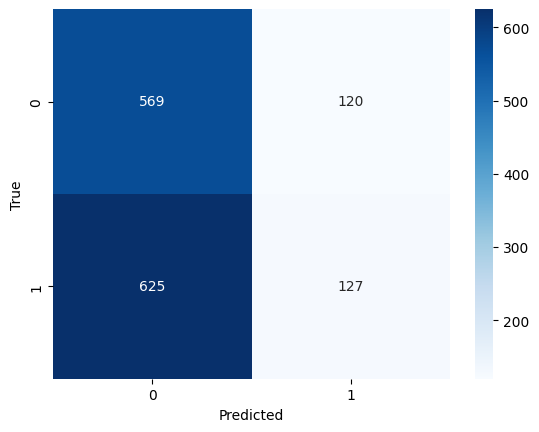

In [52]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

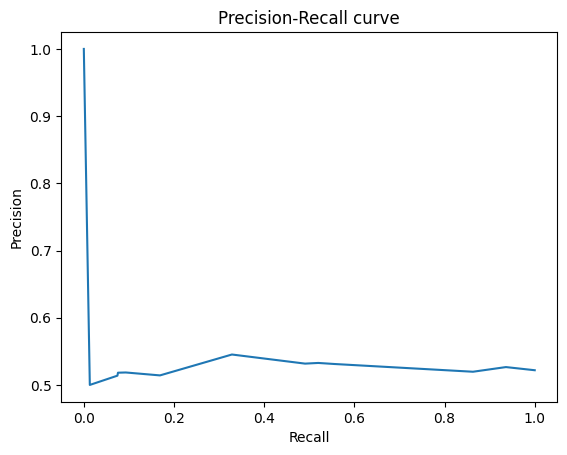

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [54]:
lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbosity=-1)
scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean())

Cross-validated accuracy: 0.5127697557227758


Final capital: 599469.9449712761
Final hodl capital: 1526287.1507723914
Sharpe Ratio: -2.6862545293968703


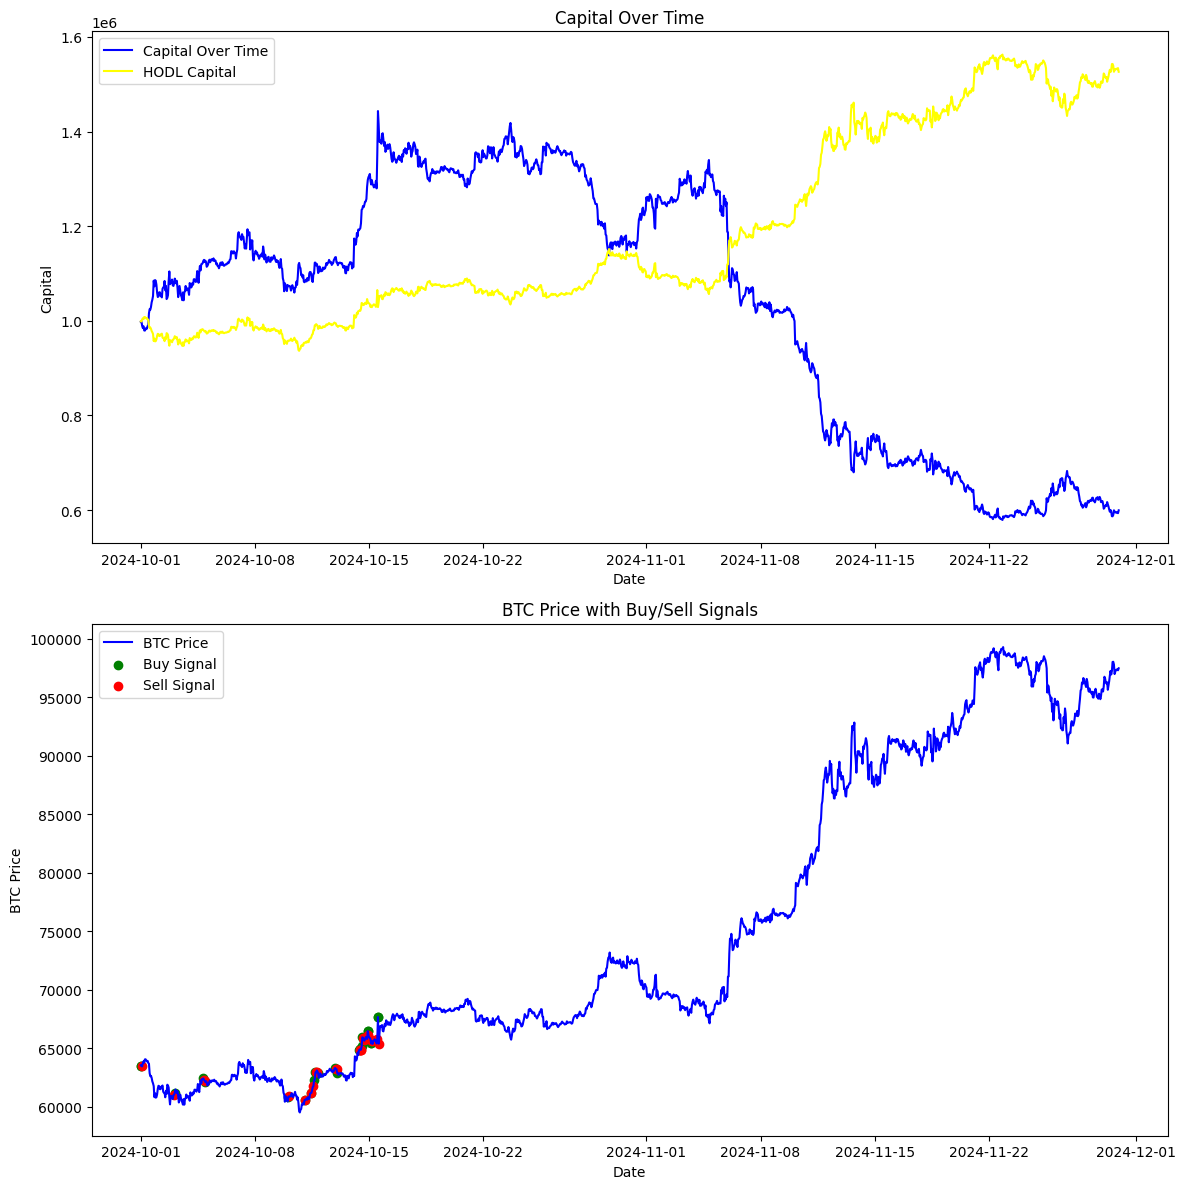

In [55]:
# 初期設定
initial_capital = 1000000
capital = initial_capital  # 初期資金をリセット
capital_history = []
positions = []
buy_signals = []
sell_signals = []

leverage = 2  # レバレッジ

# 現在のポジションの状態を示す変数
current_position = 0  # 1=ロング, -1=ショート, 0=ポジションなし

# テスト期間の日付リスト
test_dates = X_test.index

# ガチホの損益計算用
hodl_capital = initial_capital  # ガチホの初期資産
hodl_capital_history = []

# バックテストのループ
for i in range(len(test_dates) - 1):
    date = test_dates[i]
    prediction = y_pred[i]
    close_price = df.loc[date, 'close']
    next_date = test_dates[i + 1]
    next_close_price = df.loc[next_date, 'close']
    
    # ガチホの場合の資産計算
    hodl_ret = (next_close_price - close_price) / close_price
    hodl_capital *= (1 + hodl_ret)
    hodl_capital_history.append(hodl_capital)
    
    # ポジションの決定と変更
    if prediction == 1:  # 上がると予想
        if current_position == -1:  # 現在ショートなら決済してロングに変更
            sell_signals.append((date, close_price))  # ショート決済
            current_position = 1
            buy_signals.append((next_date, next_close_price))  # ロングエントリー

        elif current_position == 0:
            current_position = 1
            buy_signals.append((next_date, next_close_price))  # ロングエントリー

        else:
            current_position = 1
        

    elif prediction == 0:  # 下がると予想
        if current_position == 1:  # 現在ロングなら決済してショートに変更
            buy_signals.append((date, close_price))  # ロング決済
            current_position = -1
            sell_signals.append((next_date, next_close_price))  # ショートエントリー

        elif current_position == 0:
            current_position = -1
            sell_signals.append((next_date, next_close_price))  # ショートエントリー

        else:
            current_position = -1

    # リターンの計算
    ret = (next_close_price - close_price) / close_price * current_position * leverage
    capital = capital * (1 + ret)
    capital_history.append(capital)
    positions.append(current_position)

# バックテスト結果のデータフレーム作成
backtest_results = pd.DataFrame(index=test_dates[:-1])
backtest_results['Capital'] = capital_history
backtest_results['Hodl Capital'] = hodl_capital_history
backtest_results['Position'] = positions

# リターンの計算
backtest_results['Return'] = backtest_results['Capital'].pct_change().fillna(0)

# シャープレシオの計算（リスクフリーレートは0と仮定）
sharpe_ratio = (backtest_results['Return'].mean() / backtest_results['Return'].std()) * np.sqrt(365 * 24)

print('Final capital:', capital)
print('Final hodl capital:', hodl_capital)  # ガチホの最終資産を出力
print('Sharpe Ratio:', sharpe_ratio)

# 資産推移と売買のプロット
plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)
plt.plot(backtest_results.index, backtest_results['Capital'], label='Capital Over Time', color='blue')
plt.plot(backtest_results.index, backtest_results['Hodl Capital'], label='HODL Capital', color='yellow')  # ガチホの損益
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)
plt.plot(df.loc[test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()


In [56]:
# リターン計算やポジションサイズの確認
print("Return:", ret)

Return: 0.01009521855120054


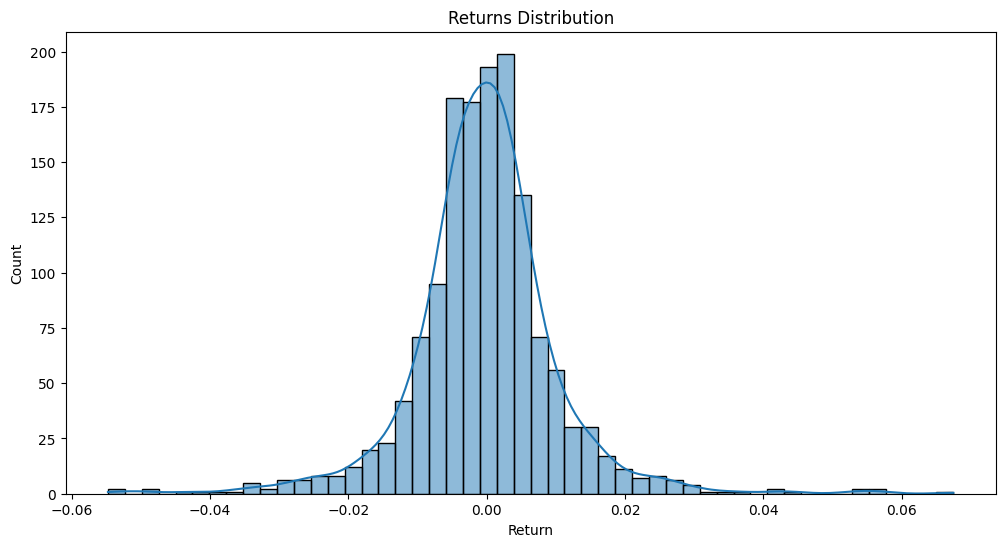

In [57]:
# リターン分布のプロット
plt.figure(figsize=(12,6))
sns.histplot(backtest_results['Return'], bins=50, kde=True)
plt.title('Returns Distribution')
plt.show()

In [58]:
backtest_results['Return']

timestamp
2024-10-01 00:00:00    0.000000
2024-10-01 01:00:00    0.000449
2024-10-01 02:00:00   -0.008818
2024-10-01 03:00:00   -0.004565
2024-10-01 04:00:00    0.003725
                         ...   
2024-11-29 19:00:00    0.000447
2024-11-29 20:00:00   -0.001605
2024-11-29 21:00:00    0.001918
2024-11-29 22:00:00   -0.003439
2024-11-29 23:00:00    0.010095
Name: Return, Length: 1440, dtype: float64

In [59]:
# モデルの保存
gbm.save_model('lightgbm_btc_model.txt')

In [60]:
print(y_pred[-10:])

[0 0 0 0 0 0 0 0 0 0]


# ハイパーパラメータチューニング

In [61]:
#break

In [62]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np
from lightgbm import early_stopping

# Optunaによるハイパーパラメータ調整
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'class_weight': 'balanced',
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_bin': trial.suggest_int('max_bin', 200, 500),  # max_binの追加
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),  # min_split_gainの追加
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),  # feature_fractionの追加
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),  # bagging_fractionの追加
        'bagging_seed': 42,
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),  # L1正則化
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),  # L2正則化
        'random_state': 42,
        'device_type': 'cpu'  # GPUが使用可能なら 'gpu' に変更
    }

    model = lgb.LGBMClassifier(**param)
    
    # クロスバリデーションの設定
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train):
        model.fit(
            X_train.iloc[train_idx], y_train.iloc[train_idx],
            eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])],
            callbacks=[early_stopping(stopping_rounds=100, verbose=False)]
        )
        preds = model.predict(X_train.iloc[val_idx])
        scores.append(accuracy_score(y_train.iloc[val_idx], preds))
    
    return np.mean(scores)

# Optunaによるパラメータ探索の実行
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # n_trialsを増加してより多くの試行を行う

# 最適なパラメータの出力
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


[I 2024-12-17 09:09:40,825] A new study created in memory with name: no-name-c9727725-7d21-4982-96aa-e2ffad5c71b0
[I 2024-12-17 09:09:42,050] Trial 0 finished with value: 0.5080990386359514 and parameters: {'n_estimators': 839, 'max_depth': 4, 'learning_rate': 0.014473992920146842, 'num_leaves': 88, 'max_bin': 266, 'min_child_samples': 36, 'min_child_weight': 0.28033811690470295, 'min_split_gain': 0.26229052369862693, 'subsample': 0.6392377319752589, 'subsample_freq': 6, 'colsample_bytree': 0.6863868133607812, 'reg_alpha': 0.5500604058389114, 'reg_lambda': 0.7675098195604992, 'feature_fraction': 0.9891703556545582, 'bagging_fraction': 0.7797824369688056, 'lambda_l1': 0.9589449554719442, 'lambda_l2': 4.588598691217728}. Best is trial 0 with value: 0.5080990386359514.
[I 2024-12-17 09:09:43,115] Trial 1 finished with value: 0.5215536005804463 and parameters: {'n_estimators': 876, 'max_depth': 17, 'learning_rate': 0.05116099605676522, 'num_leaves': 219, 'max_bin': 408, 'min_child_samples'

Best parameters: {'n_estimators': 401, 'max_depth': 4, 'learning_rate': 0.08788276789541605, 'num_leaves': 214, 'max_bin': 248, 'min_child_samples': 42, 'min_child_weight': 7.820505393865309, 'min_split_gain': 0.0990099183461608, 'subsample': 0.7884730790999412, 'subsample_freq': 6, 'colsample_bytree': 0.7092118179583521, 'reg_alpha': 0.8053109586465568, 'reg_lambda': 0.22757889112187543, 'feature_fraction': 0.5727495679386285, 'bagging_fraction': 0.6309936514977121, 'lambda_l1': 2.506085423742452, 'lambda_l2': 3.73632090324186}
Best score: 0.5571331398512607


In [63]:
# 最適なパラメータの取得
best_params = study.best_params

# 最適なパラメータを使用して再度モデルを訓練
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.6309936514977121,
               colsample_bytree=0.7092118179583521,
               feature_fraction=0.5727495679386285, lambda_l1=2.506085423742452,
               lambda_l2=3.73632090324186, learning_rate=0.08788276789541605,
               max_bin=248, max_depth=4, min_child_samples=42,
               min_child_weight=7.820505393865309,
               min_split_gain=0.0990099183461608, n_estimators=401,
               num_leaves=214, reg_alpha=0.8053109586465568,
               reg_lambda=0.22757889112187543, subsample=0.7884730790999412,
               subsample_freq=6)

In [64]:
# 評価
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # クラス1の確率
tune_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # 確率を使ってAUCを計算

print(f'Accuracy: {tune_accuracy:.4f}, ROC AUC: {roc_auc:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.5163, ROC AUC: 0.5239
              precision    recall  f1-score   support

           0       0.49      0.56      0.53       689
           1       0.54      0.47      0.50       752

    accuracy                           0.52      1441
   macro avg       0.52      0.52      0.52      1441
weighted avg       0.52      0.52      0.52      1441



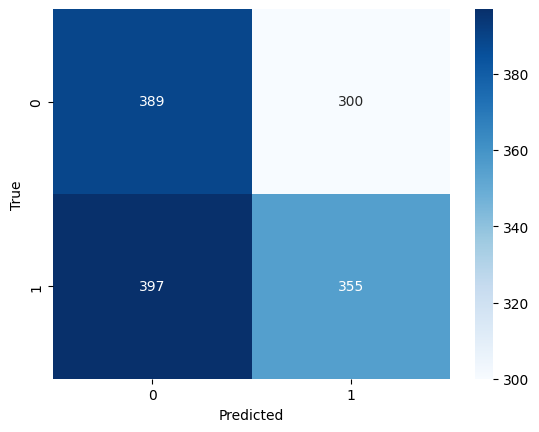

In [65]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

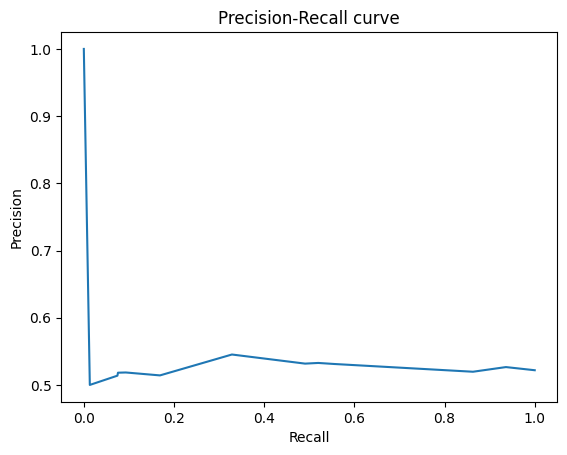

In [66]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [67]:
lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbosity=-1)
scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean())

Cross-validated accuracy: 0.5127697557227758


Final tune_capital: 1195284.1726221275
Final hodl_capital: 1526287.1507723914
Sharpe Ratio: 1.6142550008225174


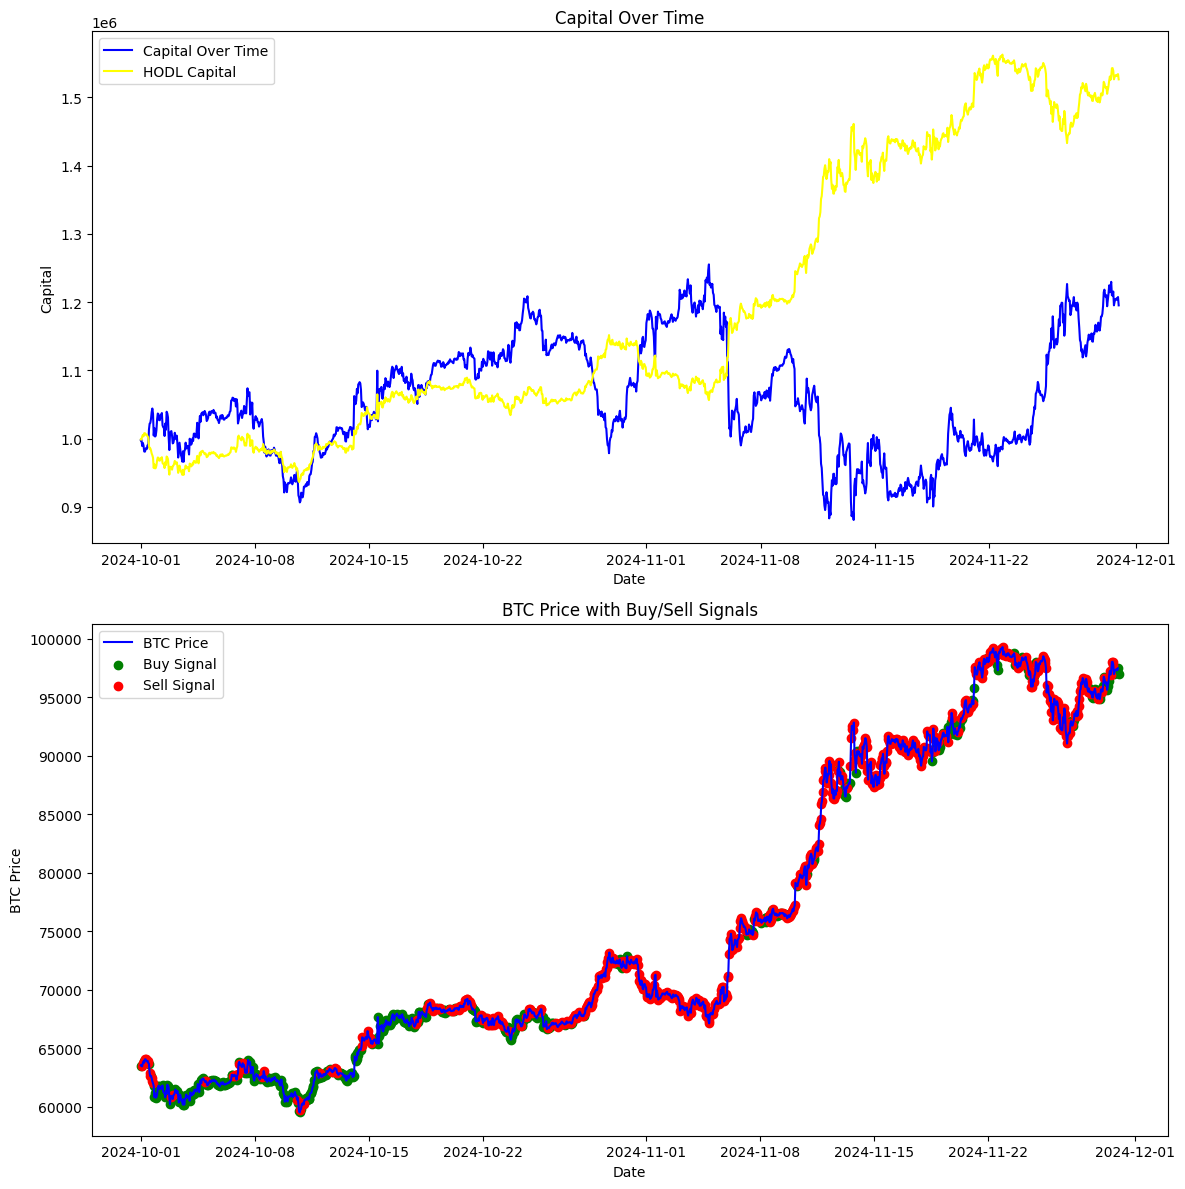

In [68]:
# バックテストの実行
# 取引シミュレーション
tune_capital = initial_capital  # 初期資金をリセット
capital_history = []
positions = []
buy_signals = []
sell_signals = []

# ガチホの損益計算用
hodl_capital = initial_capital  # ガチホの初期資金
hodl_capital_history = []

for i in range(len(test_dates)-1):
    date = test_dates[i]
    prediction = y_pred[i]
    close_price = df.loc[date, 'close']
    next_date = test_dates[i+1]
    next_close_price = df.loc[next_date, 'close']
    
    # ガチホの場合の資産計算
    hodl_ret = (next_close_price - close_price) / close_price
    hodl_capital *= (1 + hodl_ret)
    hodl_capital_history.append(hodl_capital)
    
    # ポジションの決定
    if prediction == 1:
        position = 1  # ロング
        buy_signals.append((next_date, next_close_price))  # 買いのシグナル
    else:
        position = -1  # ショート
        sell_signals.append((next_date, next_close_price))  # 売りのシグナル
    
    # リターンの計算
    ret = (next_close_price - close_price) / close_price * position * leverage
    tune_capital = tune_capital * (1 + ret)
    capital_history.append(tune_capital)
    positions.append(position)

# バックテスト結果のデータフレーム作成
backtest_results = pd.DataFrame(index=test_dates[:-1])
backtest_results['tune_capital'] = capital_history
backtest_results['hodl_capital'] = hodl_capital_history
backtest_results['Position'] = positions

# リターンの計算
backtest_results['Return'] = backtest_results['tune_capital'].pct_change().fillna(0)

# シャープレシオの計算（リスクフリーレートは0と仮定）
tune_sharpe_ratio = (backtest_results['Return'].mean() / backtest_results['Return'].std()) * np.sqrt(365 * 24)

print('Final tune_capital:', tune_capital)
print('Final hodl_capital:', hodl_capital)
print('Sharpe Ratio:', tune_sharpe_ratio)

# 資産推移と売買のプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)  # 2行1列のグラフの1番目
plt.plot(backtest_results.index, backtest_results['tune_capital'], label='Capital Over Time', color='blue')
plt.plot(backtest_results.index, backtest_results['hodl_capital'], label='HODL Capital', color='yellow')  # ガチホの損益
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)  # 2行1列のグラフの2番目
plt.plot(df.loc[test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()


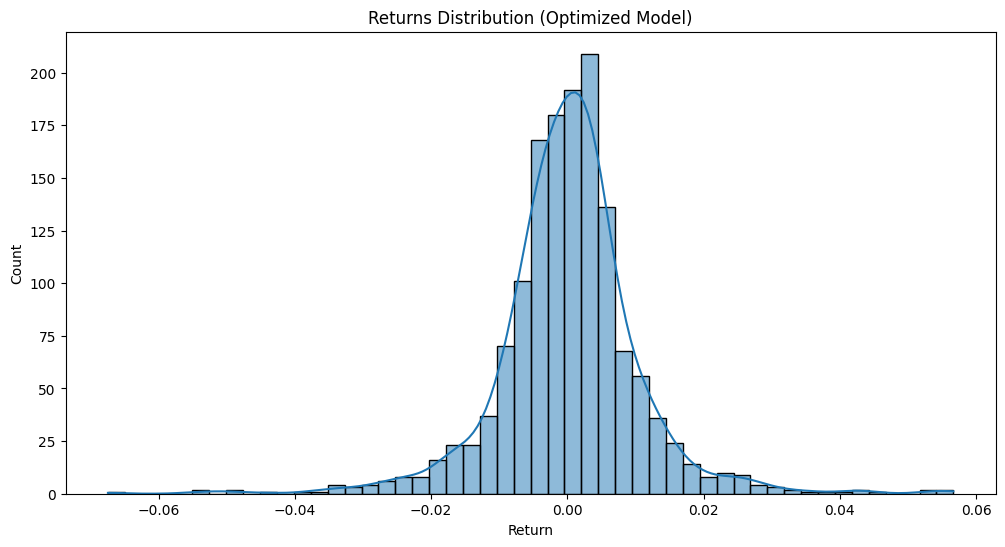

In [69]:
# リターン分布のプロット
plt.figure(figsize=(12,6))
sns.histplot(backtest_results['Return'], bins=50, kde=True)
plt.title('Returns Distribution (Optimized Model)')
plt.show()

In [70]:
backtest_results['Return']

timestamp
2024-10-01 00:00:00    0.000000
2024-10-01 01:00:00    0.000449
2024-10-01 02:00:00   -0.008818
2024-10-01 03:00:00    0.004565
2024-10-01 04:00:00   -0.003725
                         ...   
2024-11-29 19:00:00   -0.000447
2024-11-29 20:00:00    0.001605
2024-11-29 21:00:00   -0.001918
2024-11-29 22:00:00    0.003439
2024-11-29 23:00:00   -0.010095
Name: Return, Length: 1440, dtype: float64

In [71]:
# 最適化されたモデルの保存
joblib.dump(best_model, 'lightgbm_btc_model_optimized.pkl')

print("モデルを保存しました: lightgbm_btc_model_optimized.pkl")

モデルを保存しました: lightgbm_btc_model_optimized.pkl


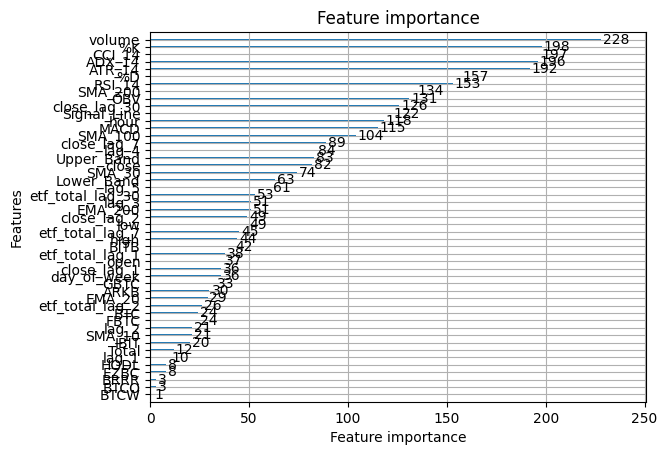

In [72]:
# 特徴量の重要度をプロット
lgb.plot_importance(best_model, max_num_features=1000)
plt.show()

In [73]:
# 保存するデータ
timeframe = '1h' 
data = {'時間足':[timeframe], 'レバレッジ':[leverage], '特徴量' : [features], 'テスト開始時期' : [split_date], '精度' : [accuracy], 
        '最終資産' : [capital], 'シャープレシオ' : [sharpe_ratio], 'チューン後精度' : [tune_accuracy], 
        'チューン後最終資産' : [tune_capital], 'チューン後シャープレシオ' : [tune_sharpe_ratio]}

df_result = pd.DataFrame(data)

# 'result.csv'が既に存在するか確認
file_exists = os.path.isfile('result.csv')

# CSVファイルに追記、ファイルが既に存在する場合はヘッダーを追加しない
df_result.to_csv('result.csv', mode='a', header=not file_exists, index=False)

In [74]:
print('Final capital:', capital)
print('Final tune_capital:', tune_capital)

Final capital: 599469.9449712761
Final tune_capital: 1195284.1726221275


In [75]:
# 予測結果をCSVファイルに保存
np.savetxt("lgb_tuned_pred.csv", y_pred, delimiter=",")

In [76]:
print(y_pred[-10:])

[0 1 1 1 1 1 1 1 1 1]
